In [1]:
# NOTE: has to be done in python 2.7 as python 3 currently not supported by the fitparse package
import numpy as np
import glob
import re
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import seaborn as sns
import fitparse
import gmplot
from scipy.signal import savgol_filter
from collections import OrderedDict
%matplotlib inline

In [2]:
filenames = glob.glob('Gary_run_*.fit')
print len(filenames)
print filenames[0]

20
Gary_run_030218.fit


In [3]:
dataframe_dict = {}
for f in filenames:
    run_date = re.findall('\d{6}', f)[0]
    fitfile = fitparse.FitFile(f)
    # Create dataframe from records in list
    record_df_list = [pd.concat([pd.DataFrame([record_data.value], columns=[record_data.name]) for record_data in record], axis=1) \
    for record in fitfile.get_messages('record')]
    df = pd.concat(record_df_list, ignore_index=True)
    # Clean up dataframe
    #df['activity_type'] = df['activity_type'].astype('category')
    df = df.drop(labels=['enhanced_altitude', 'enhanced_speed'], axis=1)
    # Convert lon, lat
    df['position_lat'] = df['position_lat'] * (180. / 2**31)
    df['position_long'] = df['position_long'] * (180. / 2**31)
    # Add to dictionary, with date as key
    dataframe_dict[run_date] = df

Probably want to drop unnecessary columns from dataframes in the for loop above so that less information is held in memory

In [4]:
dataframe_dict['061117'].head()

,activity_type,altitude,cadence,distance,fractional_cadence,heart_rate,position_lat,position_long,speed,stance_time,stance_time_balance,stance_time_percent,step_length,timestamp,unknown_61,unknown_66,vertical_oscillation,vertical_ratio
0,running,141.0,84,0.00,0.5,72,53.650016,-1.804412,1.372,268.0,54.40,37.50,567.0,2017-11-06 18:18:28,3177,425,103.5,20.40
1,running,141.2,85,7.35,0.5,75,53.650081,-1.804397,1.847,263.0,52.78,37.25,773.0,2017-11-06 18:18:31,3177,424,85.7,12.87
2,running,141.0,86,10.23,0.0,81,53.650107,-1.804392,1.885,259.0,52.37,37.00,768.0,2017-11-06 18:18:32,3176,424,87.7,12.50
3,running,141.0,86,13.33,0.0,81,53.650135,-1.804389,1.931,254.0,52.00,36.00,801.0,2017-11-06 18:18:33,3176,424,88.7,11.90
4,running,141.2,83,21.27,0.5,88,53.650204,-1.804410,2.025,263.0,52.15,37.00,926.0,2017-11-06 18:18:36,3177,424,95.5,10.81


In [5]:
for key, dframe in dataframe_dict.iteritems():
    print key
    print dframe.info()

100218
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 18 columns):
activity_type           692 non-null object
altitude                692 non-null float64
cadence                 692 non-null int64
distance                692 non-null float64
fractional_cadence      692 non-null float64
heart_rate              692 non-null int64
position_lat            692 non-null float64
position_long           692 non-null float64
speed                   692 non-null float64
stance_time             692 non-null float64
stance_time_balance     692 non-null float64
stance_time_percent     692 non-null float64
step_length             692 non-null float64
timestamp               692 non-null datetime64[ns]
vertical_oscillation    692 non-null float64
vertical_ratio          692 non-null float64
unknown_61              692 non-null int64
unknown_66              692 non-null int64
dtypes: datetime64[ns](1), float64(12), int64(4), object(1)
memory usage: 97.4+ 

We can see that the individual dataframes contain only a small percentage of null values, so can just remove these.

Also, dataframe '281217' seems to be missing a lot of the columns for some reason, so it's best to remove this one

In [6]:
del dataframe_dict['281217']

In [7]:
for key, dframe in dataframe_dict.iteritems():
    dframe = dframe.dropna()
    dataframe_dict[key] = dframe.reset_index(drop=True)

Now convert the dict keys to datetime objects so that the dataframes can be sorted in order of oldest to most recent

In [8]:
dataframe_dict_dates = {}
for key, dframe in dataframe_dict.iteritems():
    key_new = datetime.date(int('20' + key[4:]), int(key[2:4]), int(key[:2]))
    dataframe_dict_dates[key_new] = dframe
    
dataframe_dict_sorted = OrderedDict(sorted(dataframe_dict_dates.items()))
print dataframe_dict_sorted.keys()

[datetime.date(2017, 10, 8), datetime.date(2017, 10, 14), datetime.date(2017, 10, 18), datetime.date(2017, 10, 21), datetime.date(2017, 10, 24), datetime.date(2017, 10, 28), datetime.date(2017, 11, 6), datetime.date(2017, 11, 20), datetime.date(2017, 11, 26), datetime.date(2017, 12, 6), datetime.date(2017, 12, 17), datetime.date(2018, 1, 14), datetime.date(2018, 1, 18), datetime.date(2018, 1, 25), datetime.date(2018, 1, 27), datetime.date(2018, 2, 3), datetime.date(2018, 2, 10), datetime.date(2018, 2, 13), datetime.date(2018, 2, 20)]


We can finally convert this dict into a dataframe so that we can access the full set of values easily

In [9]:
df_all_sorted = pd.concat(dataframe_dict_sorted)
df_all_sorted.head()

activity_type  altitude  cadence  distance  fractional_cadence  \
2017-10-08 0       running     142.8       85      0.04                 0.0   
           1       running     142.2       86      9.70                 0.5   
           2       running     142.2       87     13.41                 0.0   
           3       running     141.8       87     22.39                 0.5   
           4       running     141.2       90     34.81                 0.0   

              heart_rate  position_lat  position_long  speed  stance_time  \
2017-10-08 0       100.0     53.650264      -1.803559  0.000        257.0   
           1       104.0     53.650262      -1.803412  1.782        245.0   
           2       106.0     53.650262      -1.803356  1.857        248.0   
           3       109.0     53.650257      -1.803221  2.053        247.0   
           4       113.0     53.650279      -1.803037  2.426        233.0   

              stance_time_balance  stance_time_percent  step_length  \
2017-10-08 0                50.06                36.00        422.0   
           1                49.75                34.75        730.0   
           2                49.43                35.75        886.0   
           3                49.46                35.75       1024.0   
           4                49.43                34.50       1126.0   

                       timestamp  unknown_61  unknown_66  \
2017-10-08 0 2017-10-08 12:19:15        3227         667   
           1 2017-10-08 12:19:18        3224         667   
           2 2017-10-08 12:19:19        3224         666   
           3 2017-10-08 12:19:21        3222         667   
           4 2017-10-08 12:19:24        3219         667   

              vertical_oscillation  vertical_ratio  
2017-10-08 0                  99.5            6.12  
           1                  87.7           12.28  
           2                  88.7           11.21  
           3                 104.2           10.15  
           4                  87.7            8.37

# Heatmap

First just use the gmplot package to plot a heatmap onto Google maps. There's not much flexibility here though

In [10]:
# Create gmplot instance with location of map centre and zoom level (1 - 20)
gmap = gmplot.GoogleMapPlotter(np.mean(dataframe_dict['030218']['position_lat']),
                               np.mean(dataframe_dict['030218']['position_long']), 13)

latitudes_all = np.array([])
longitudes_all = np.array([])
for key, dframe in dataframe_dict.iteritems():
    latitudes_all = np.append(latitudes_all, dframe['position_lat'])
    longitudes_all = np.append(longitudes_all, dframe['position_long'])
gmap.heatmap(latitudes_all, longitudes_all)
    
gmap.draw("Gary_run_multi_heatmap.html")

Now create a heatmap from scratch. This can use a 2D histogram, or the hexagonal binning method hexbin:

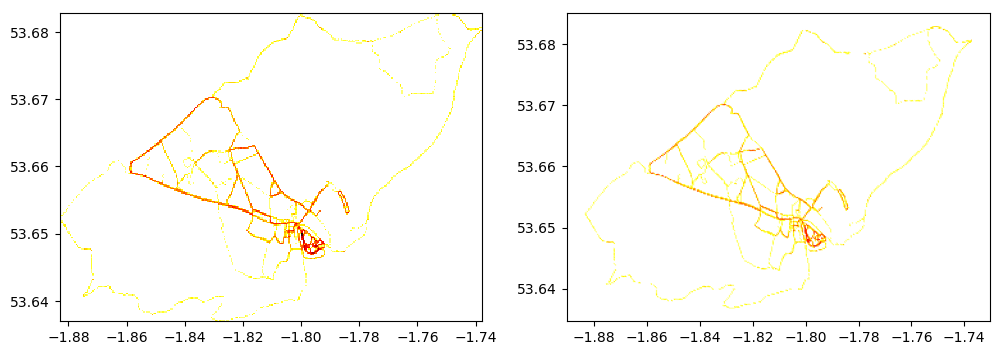

In [11]:
plt.style.use('default')
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
hist_raw = plt.hist2d(longitudes_all, latitudes_all, bins=(300, 220), norm=colors.LogNorm(), cmap='hot_r')
plt.subplot(1, 2, 2)
plt.hexbin(longitudes_all, latitudes_all, gridsize=(300, 220), bins='log', cmap='hot_r')
plt.show()

An advantage of the 2D histogram is that we can take the binned data and manually apply some smoothing:

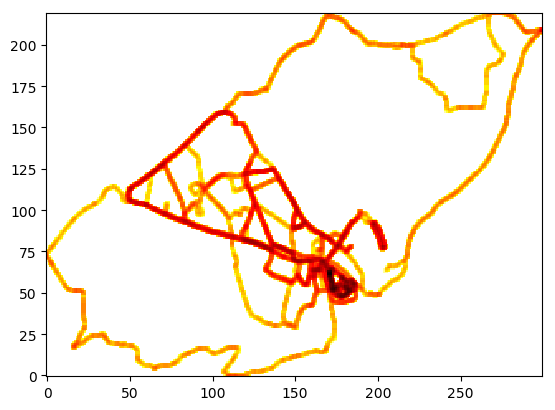

In [12]:
hist_smooth = savgol_filter(hist_raw[0], window_length=3, polyorder=1, axis=0)
hist_smooth = savgol_filter(hist_smooth, window_length=3, polyorder=1, axis=1)
plt.imshow(hist_smooth.T, interpolation='none', cmap='hot_r', origin='lower', norm=colors.LogNorm())
plt.show()

# Mean run statistics

Find mean statistics of each run and compare these.

Note that we need to take max of distance column

In [13]:
distances = df_all_sorted['distance'].groupby(level=0).max()
df_mean_stats = df_all_sorted.groupby(level=0).mean()
df_mean_stats['distance'] = distances
df_mean_stats.index.name = 'date'
df_mean_stats.head()

,altitude,cadence,distance,fractional_cadence,heart_rate,position_lat,position_long,speed,stance_time,stance_time_balance,stance_time_percent,step_length,unknown_61,unknown_66,vertical_oscillation,vertical_ratio
date,,,,,,,,,,,,,,,,
2017-10-08,197.012766,89.454407,10538.19,0.260638,172.110942,53.658299,-1.823262,3.537696,240.851064,49.797781,35.959726,1176.887538,3498.066869,666.972644,85.310334,7.121216
2017-10-14,152.745008,89.514593,10090.73,0.247312,168.637481,53.652148,-1.803892,3.648727,239.849462,49.298356,35.723886,1205.878648,3286.500768,618.777266,85.674040,6.986298
2017-10-18,212.688406,88.742029,10171.33,0.254348,167.791304,53.658504,-1.827939,3.530064,243.550725,48.951261,36.124638,1183.492754,3580.320290,-249.120290,88.313333,7.310812
2017-10-21,152.119755,90.730475,9997.54,0.263400,167.235835,53.652076,-1.803803,3.752695,238.852986,49.817749,36.156202,1225.686064,3302.730475,-1864.866769,86.027259,6.911930
2017-10-24,142.734277,87.792453,10187.44,0.257075,168.786164,53.649065,-1.798479,3.515646,245.698113,49.250063,35.992138,1188.312893,3278.944969,144.275157,88.990252,7.359780


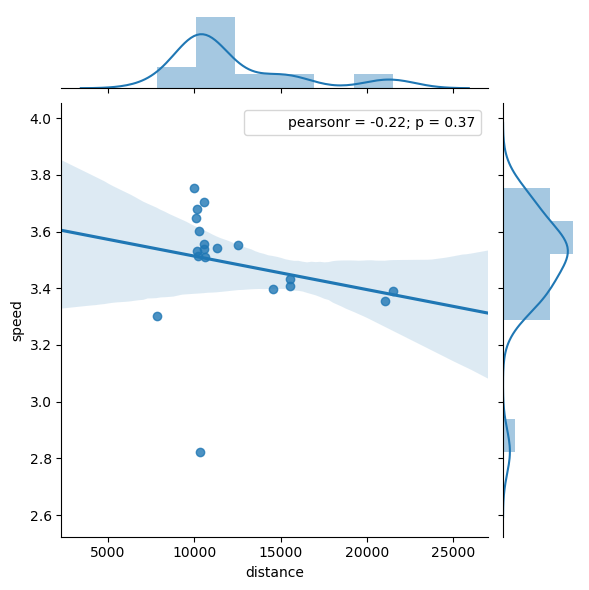

In [14]:
sns.jointplot(x='distance', y='speed', data=df_mean_stats, kind='reg')
plt.show()

It seems like there could be a loose correlation between the mean run speed and the total distance. There is still quite a range of run distances here though, so to investigate other statistics it would be best to concentrate on just the runs of length ~ 10km so that we remove any hidden effects of run distance on correlations between other statistics

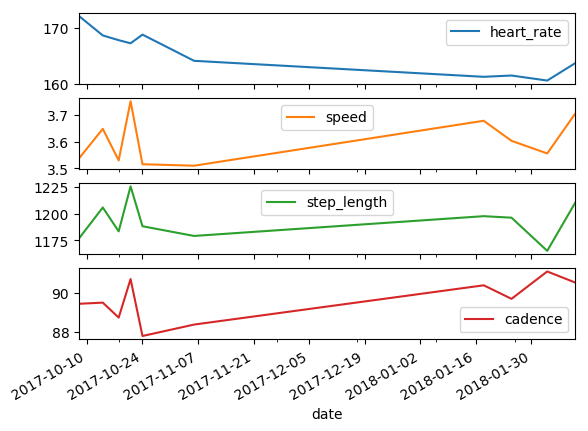

In [15]:
df_mean_stats_10k = df_mean_stats[(df_mean_stats['distance'] > 9000) & (df_mean_stats['distance'] < 11000)]
df_mean_stats_10k[df_mean_stats_10k['cadence'] > 80][['heart_rate', 'speed', 'step_length', 'cadence']].plot(subplots=True)
plt.show()

There is a clear improvement over time since October for 10km runs. The average heart rate is lower, while the average speed, step length and cadence (steps per minute) have all increased.

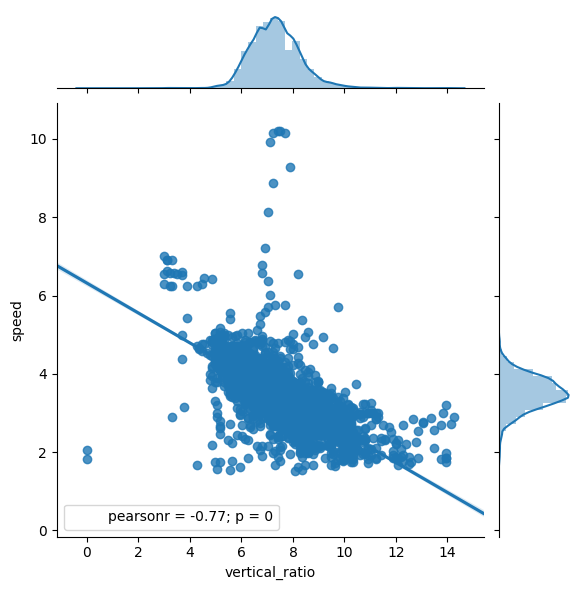

In [16]:
df_all_speed_vo = df_all_sorted[(df_all_sorted['speed'] > 1.5) \
                                & (df_all_sorted['vertical_ratio'] < 15)][['speed', 'vertical_ratio']]
sns.jointplot(x='vertical_ratio', y='speed', data=df_all_speed_vo, kind='reg')
plt.show()

The gradient could be a useful statistic for these runs. To calculate gradient we need to calculate the equivalent distance along the surface of the Earth in each timestep, and divide the change in altitude by this.

In [18]:
r_Ee = 6378.137e3  # Equatorial radius of Earth (m)
r_Ep = 6356.752e3  # Polar radius of Earth (m)
def lat_deg2m(latitude):
    return latitude * (2*r_Ep*np.pi) / 360.

def lon_deg2m(longitude, latitude):
    d_lat = 2 * r_Ee * np.sin((np.pi / 180.) * 2 * (90. - latitude) / 2)  # diameter of circular slice at lat_deg latitude
    return longitude * (d_lat * np.pi) / 360.

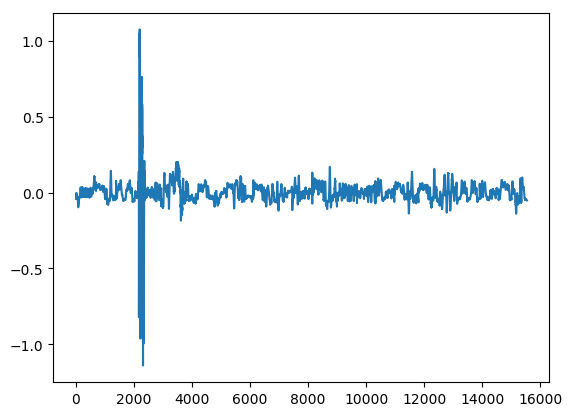

In [25]:
gradient_all = np.array([])
for key, dframe in dataframe_dict.iteritems():
    grad_dframe = np.array([])
    for i in range(dframe.shape[0] - 1):
        delta_lat = lat_deg2m(np.abs(dframe['position_lat'].iloc[i+1] - dframe['position_lat'].iloc[i]))
        delta_long = lon_deg2m(np.abs(dframe['position_long'].iloc[i+1] - dframe['position_long'].iloc[i]),
                               dframe['position_lat'].iloc[i])
        delta_distance = np.sqrt(delta_lat ** 2 + delta_long ** 2)
        if delta_distance == 0.:
            grad = np.nan
        else:
            grad = (dframe['altitude'].iloc[i+1] - dframe['altitude'].iloc[i]) / delta_distance
        grad_dframe = np.append(grad_dframe, grad)
    grad_mask = np.isnan(grad_dframe)
    grad_dframe[grad_mask] = np.nanmedian(grad_dframe)
    grad_dframe_smooth = savgol_filter(grad_dframe, window_length=55, polyorder=3)
    grad_dframe_smooth[grad_mask] = np.nan
    gradient_all = np.append(gradient_all, grad_dframe_smooth)

plt.plot(gradient_all)

In [ ]:
# plot heart rate vs gradient
# Are huge gradients genuine? Steps maybe?